In [113]:
import Pkg
Pkg.activate("MMLDS_project")
using DynamicalSystems, ReservoirComputing, Plots, Printf
using DifferentialEquations
using OrdinaryDiffEq

In [114]:
#include("MMLDS_reservoir_Tom_working.jl")
#include("data.jl")
#include("ReservoirComputing.jl")

## Ways to generate Data

In [115]:
#generate data 1 
#function lorenz(u, p, t)
#    x, y, z = u
#    σ, ρ, β = p
#    dx = σ * (y - x)
#    dy = x * (ρ - z) - y
#    dz = x * y - β * z
#return [dx, dy, dz]
#end#

#p_lorenz = [10, 28, 8/3] 
#tspan = (0.,100.)
#dt = 0.01

#x0 = [1., 1., 1.]

#prob = ODEProblem(lorenz, x0, tspan, p_lorenz) 
#sol = solve(prob, Tsit5())

In [116]:
#generate data 2
#create a lorenz dynamical system:
#function lorenz(u, p, t)
#    x, y, z = u
#    σ, ρ, β = p
#    dx = σ * (y - x)
##    dy = x * (ρ - z) - y
 #   dz = x * y - β * z
#    return SVector{3}(dx, dy, dz)
    #return dx,dy,dz
#end 
#x0 = [1., 1., 1.]
#contLorenzDiff = ContinuousDynamicalSystem(lorenz,x0,[10, 28, 8/3])

#T = 100.0
#t_start = 0.
#t_end = 100.
#dt = 0.01
#Ttr = 0 # extra time to evolve the system before application of algorithm
#saveat = t_start:dt:t_end

#tr = trajectory(contLorenzDiff, T, Δt = Δt, Ttr = Ttr)
#tr = trajectory(contLorenzDiff, T, Δt = Δt, Ttr = Ttr, alg = Tsit5(),save_idx = saveat)
#tr = trajectory(contLorenzDiff, 100, dt = 0.01)
#x, y, z = columns(tr)

# Put the data in the matrix format (n_features, n_samples) required by ReservoirComputing.jl 
#sol = reduce(vcat, [x, y, z]')

In [117]:
#kein Erzeugen der Daten  mit diesen Methoden möglich - warum? (mehr argumente in create data)
#d_tobi = create_data(x0 = [1.,1.,1.],dt = 0.01, tstart = 0., tend = 100.)
#d_tobi2 = create_data(x0 = [1.,1.,1.],dt = 0.01, tstart = 0., tend = 50.)
#for i in 1:50
#    j = 0
#    if(d_tobi[i] != d_tobi2[i])
#        print(false)
#    else
#        j = j+1
#    end
#    print(j)
#end

In [118]:
#vergleiche generierte daten:
#sol_trans = transpose(sol)
#d_tob_transpose = transpose(d_tobi)
#fl_sol_data = convert(Float64, sol_trans[:,1,1])
#for i in 1:1001
#    if (sol_trans[i,1,1] != round(d_tob_transpose[i],5))
#        print(i)
#    end
#end  
#print(fl_sol_data)

#print(sol[:,1,1])
#sol[:,3]
#typeof(d_tobi)

In [119]:
#convert matrix into vector:
#V = Vector{Float64}([1.,1.,1.])

#typeof(sol[:,1])
#typeof(sol[1,1])
#a = sol[1,1]
#b = sol[2,1]
#c = sol[3,3]
#typeof([a,b,c])
##V[0]
#typeof(d_tobi[1:3])
#push!(V, sol[:,1])
#for i in 2:1001
#    a = sol[1,i]
#    b = sol[2,i]
#    c = sol[3,i]
#    push!(V, [a,b,c])
#end
#print(V)

# Parameter Search grid

In [120]:
# Set up the hyperparameter grid-search
param_grid = []

reservoir_sizes = [512, 1024]
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03]#[0.03, 0.05]
input_scales = [0.1]
ridge_values = [0.0]#[0.0, 1e-6, 1e-5]
# Take the Cartesian product of the possible values
for params in Iterators.product(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)
    push!(param_grid, ESNHyperparams(params...))
end

## Learning and Plotting

In [121]:
sol = create_data()

# compute the solution
println(length(param_grid), " hyperparameter combinations.")
#λ_max = lyapunov(contLorenzDiff,100, Ttr = 100)
#print(λ_max)
train_data, val_data, test_data = train_val_test_split(sol, val_seconds = 15, test_seconds = 15)
@time esn, Wₒᵤₜ = cross_validate_esn(train_data, val_data, param_grid)
esn, Wₒᵤₜ = cross_validate_esn(train_data, val_data, param_grid)

(ESN{Int64, Matrix{Float64}, Default, NLADefault, Matrix{Float64}, RNN{typeof(NNlib.tanh_fast), Float64}, Matrix{Float64}, Matrix{Float64}, StandardStates, Int64, Matrix{Float64}}(510, [1.0 1.0125211986027804 … 2.942149234942646 3.1265369070761118; 1.0 1.259976831542161 … 4.73478456979376 5.025291727360335; 1.0 0.9848951848648358 … 16.971101647131672 16.670594105477964], Default(), NLADefault(), [-0.05267047708577913 0.0 0.0; 0.07359641561780758 0.0 0.0; … ; 0.0 0.0 -0.019169072633528114; 0.0 0.0 0.04719989993940424], RNN{typeof(NNlib.tanh_fast), Float64}(NNlib.tanh_fast, 1.0), [0.0 0.0 … 0.0 0.0; 0.0 0.05812587790107485 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0; 0.0; … ; 0.0; 0.0;;], StandardStates(), 0, [-0.05262182529268505 0.008947255925121805 … 0.4567992646465212 0.4613129323869119; 0.0734638262052118 0.0631806249092134 … -0.33897736435118075 -0.32255378145150687; … ; -0.01916672506528563 -0.07327036549678548 … -0.6873682271092516 -0.6886418203794705; 0.0471648800

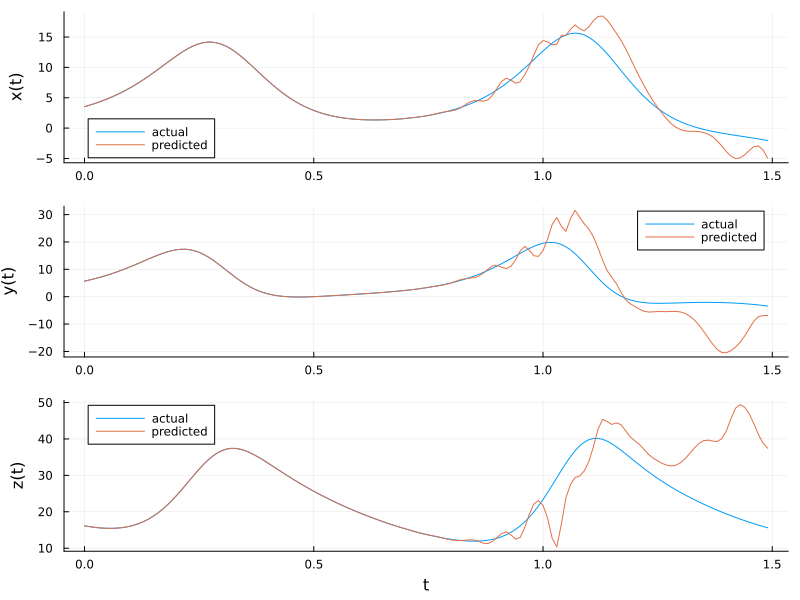

In [122]:
"""
    plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)

Given an Echo State Network, plot its predictions versus the given test set.
"""
function plot_prediction(esn, Wₒᵤₜ, test_data)
    steps_to_predict = size(test_data, 2)
    prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
    dt = 0.01
    label = ["actual" "predicted"]
    times = dt * collect(0:steps_to_predict)[1:end-1] 

    p1 = plot(times, [test_data[1, :], prediction[1, :]], label = label, ylabel = "x(t)")
    p2 = plot(times, [test_data[2, :], prediction[2, :]], label = label, ylabel = "y(t)")
    p3 = plot(times, [test_data[3, :], prediction[3, :]], label = label, ylabel = "z(t)", xlabel = "t")
    plot(p1, p2, p3, layout = (3, 1), size = (800, 600))
end
plot_prediction(esn, Wₒᵤₜ, test_data)